In [49]:
from lib import read_file

import numpy as np

from dataclasses import dataclass

In [67]:
lines = read_file("10_input.txt")
arr = np.empty(shape=(len(lines), len(lines[0])), dtype=str)
for i in range(len(lines)):
    for j in range(len(lines[0])):
        arr[i, j] = lines[i][j]

arr

array([['F', '-', 'F', ..., '7', 'F', '-'],
       ['L', 'J', '|', ..., 'F', '-', 'J'],
       ['L', '.', '|', ..., 'L', '-', '|'],
       ...,
       ['-', '|', '-', ..., 'F', 'F', 'F'],
       ['L', 'L', '.', ..., '-', '-', 'J'],
       ['L', 'J', '-', ..., 'J', 'F', 'J']], dtype='<U1')

In [68]:
start_idx = np.where(arr == "S")
start_idx = tuple(a[0] for a in start_idx)
start_idx

(63, 62)

In [69]:
def find_connected_pipes(arr, idx: tuple[int, int]) -> list[tuple[int, int]]:
    connected_idxs = []
    # Above
    if arr[idx[0] - 1, idx[1]] in ["|", "7", "F"]:
        connected_idxs.append((idx[0] - 1, idx[1]))
    # Right
    if arr[idx[0], idx[1] + 1] in ["-", "7", "J"]:
        connected_idxs.append((idx[0], idx[1] + 1))
    # Below
    if arr[idx[0] + 1, idx[1]] in ["|", "L", "J"]:
        connected_idxs.append((idx[0] + 1, idx[1]))
    # Left
    if arr[idx[0], idx[1] - 1] in ["-", "F", "L"]:
        connected_idxs.append((idx[0], idx[1] - 1))

    return connected_idxs

In [94]:
connected = find_connected_pipes(arr, start_idx)

North = np.array((-1, 0), dtype=int)
South = np.array((1, 0), dtype=int)
East = np.array((0, 1), dtype=int)
West = np.array((0, -1), dtype=int)

pipe_mapping = {
        "|": (North, South),
        "-": (East, West),
        "L": (North, East),
        "J": (North, West),
        "7": (South, West),
        "F": (South, East),
    }

@dataclass
class Route:
    current_idx: tuple[int, int]
    previous_idx: tuple[int, int]
    nsteps: int

    def take_step(self, arr, arr_numeric=None):
        symbol = arr[tuple(self.current_idx)]
        steps = pipe_mapping[symbol]
        for s in steps:
            if not np.all((new_idx := (self.current_idx + s)) == self.previous_idx):
                self.previous_idx = self.current_idx
                self.current_idx = new_idx
                self.nsteps += 1

                if arr_numeric is not None:
                    # Mark path
                    arr_numeric[tuple(self.current_idx)] = -1

                    for check_idx in [self.previous_idx, self.current_idx]:
                        if np.all((self.previous_idx - self.current_idx) == North):
                            idx = tuple(check_idx + East)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 2
                            idx = tuple(check_idx + West)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 4

                        elif np.all((self.previous_idx - self.current_idx) == South):
                            idx = tuple(check_idx + East)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 4
                            idx = tuple(check_idx + West)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 2

                        elif np.all((self.previous_idx - self.current_idx) == East):
                            idx = tuple(check_idx + North)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 4
                            idx = tuple(check_idx + South)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 2

                        elif np.all((self.previous_idx - self.current_idx) == West):
                            idx = tuple(check_idx + North)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 2
                            idx = tuple(check_idx + South)
                            if arr_numeric[idx] == 0:
                                arr_numeric[idx] = 4

                break
                


In [95]:
route1 = Route(connected[0], start_idx, 1)
route2 = Route(connected[1], start_idx, 1)


while True:
    if (
            np.all(route1.current_idx == route2.current_idx) or
            np.all(route1.previous_idx == route2.current_idx)
        ):
        break

    route1.take_step(arr)
    route2.take_step(arr)

max(route1.nsteps, route2.nsteps)


7093

# Part 2

In [110]:
lines = read_file("10_input.txt")
arr = np.empty(shape=(len(lines), len(lines[0])), dtype=str)
for i in range(len(lines)):
    for j in range(len(lines[0])):
        arr[i, j] = lines[i][j]

arr = np.pad(arr, pad_width=((1, 1), (1, 1)), constant_values='.')


start_idx = np.where(arr == "S")
start_idx = tuple(a[0] for a in start_idx)
connected = find_connected_pipes(arr, start_idx)

arr_numeric = np.zeros(arr.shape)

# Only take a single route
route1 = Route(connected[0], start_idx, 1)
arr_numeric[connected[0]] = -1

while True:
    if arr[tuple(route1.current_idx)] == "S":
        break

    route1.take_step(arr, arr_numeric)

# 
arr_numeric

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

407

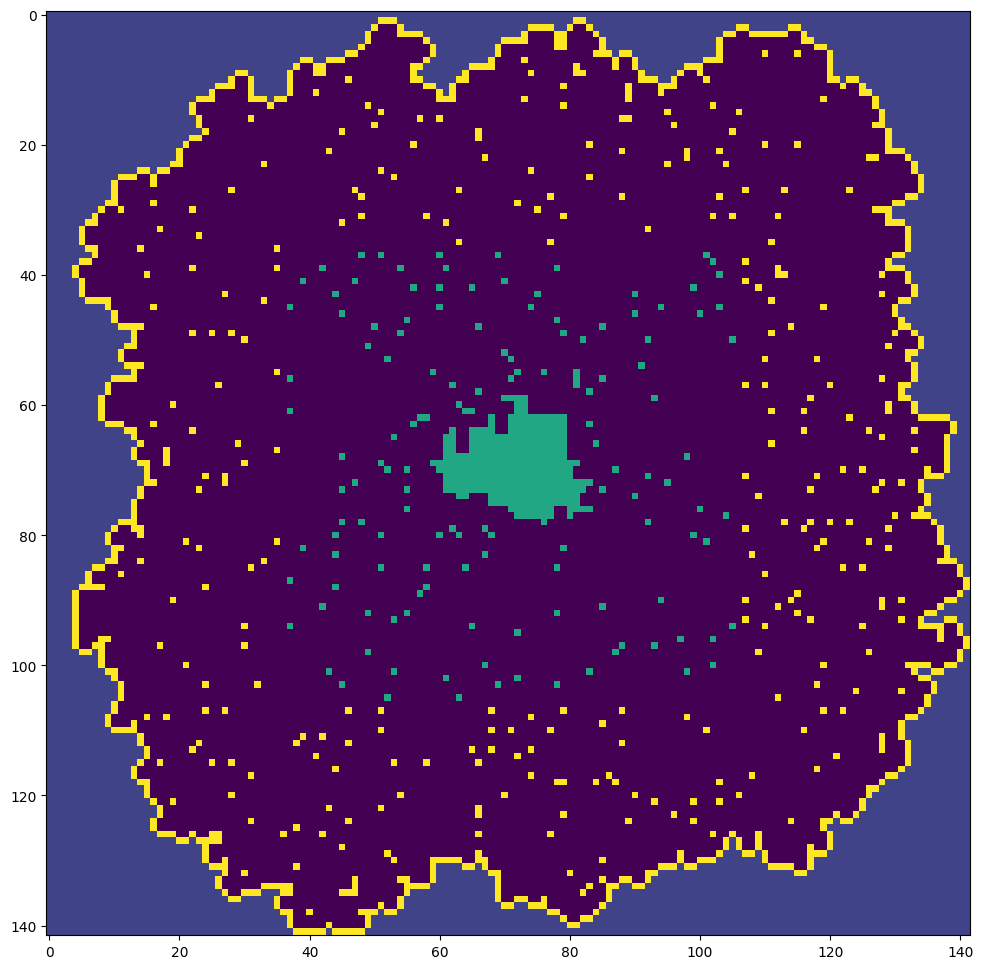

In [112]:
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill

arr_numeric = flood_fill(arr_numeric, (70, 70), new_value=2)

fig = plt.figure(figsize=(12, 12))
plt.imshow(arr_numeric)

np.sum(arr_numeric == 2)